## Train a VAE

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu not relevant here
[500, 125, 31, 4]
Epoch: 0, Loss: 40.3697292804718
Epoch: 1, Loss: 39.00453269481659
Epoch: 2, Loss: 38.198583245277405
Epoch: 3, Loss: 37.60185241699219
Epoch: 4, Loss: 37.07188391685486
Epoch: 5, Loss: 36.48355007171631
Epoch: 6, Loss: 35.995776891708374
Epoch: 7, Loss: 35.4049596786499
Epoch: 8, Loss: 34.9353461265564
Epoch: 9, Loss: 34.4344407916069
Epoch: 10, Loss: 33.87390500307083
Epoch: 11, Loss: 33.16110134124756
Epoch: 12, Loss: 32.592224419116974
Epoch: 13, Loss: 32.07969909906387
Epoch: 14, Loss: 31.70951521396637
Epoch: 15, Loss: 31.33249592781067
Epoch: 16, Loss: 31.19753110408783
Epoch: 17, Loss: 31.09170776605606
Epoch: 18, Loss: 30.846536457538605
Epoch: 19, Loss: 30.669292867183685
Epoch: 20, Loss: 30.579966485500336
Epoch: 21, Loss: 30.53208464384079
Epoch: 22, Loss: 30.461491584777832
Epoch: 23, Loss: 30.313803613185883
Epoch: 24, Loss: 30.333262145519257
Epoch: 25, Loss: 30.2915877699852
Epoch: 26, Loss: 30.104828119277954
Epoch: 27, Loss: 30.

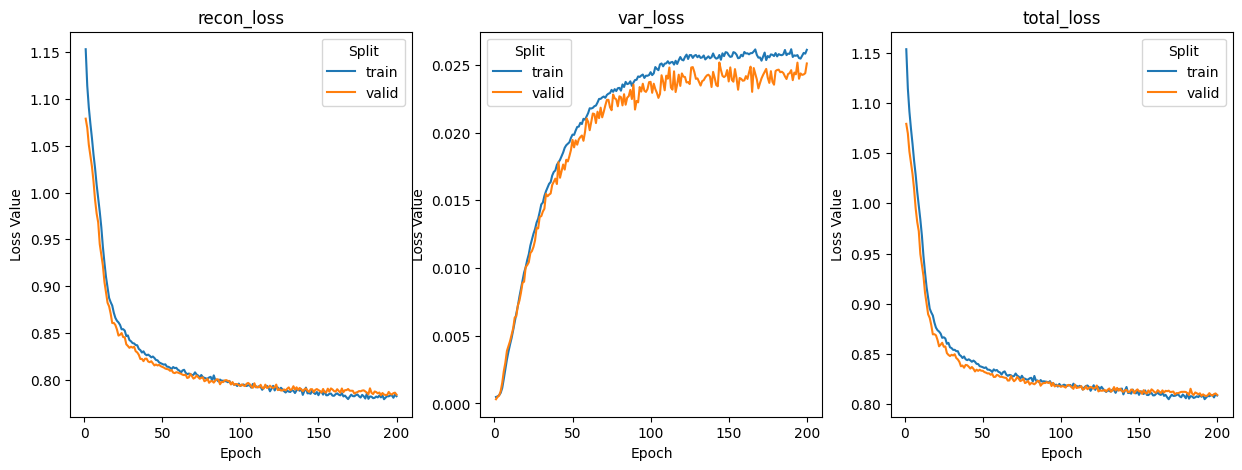

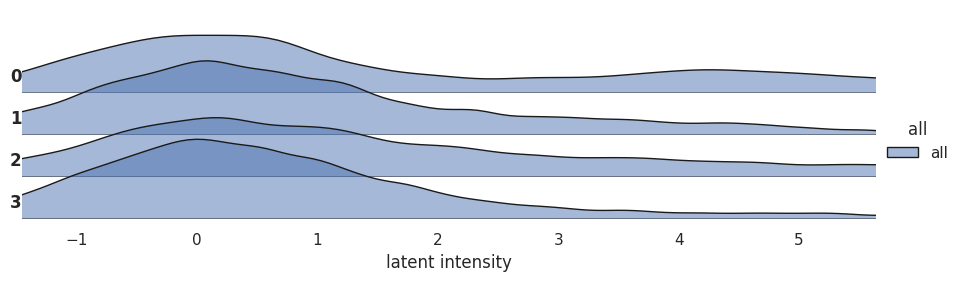

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


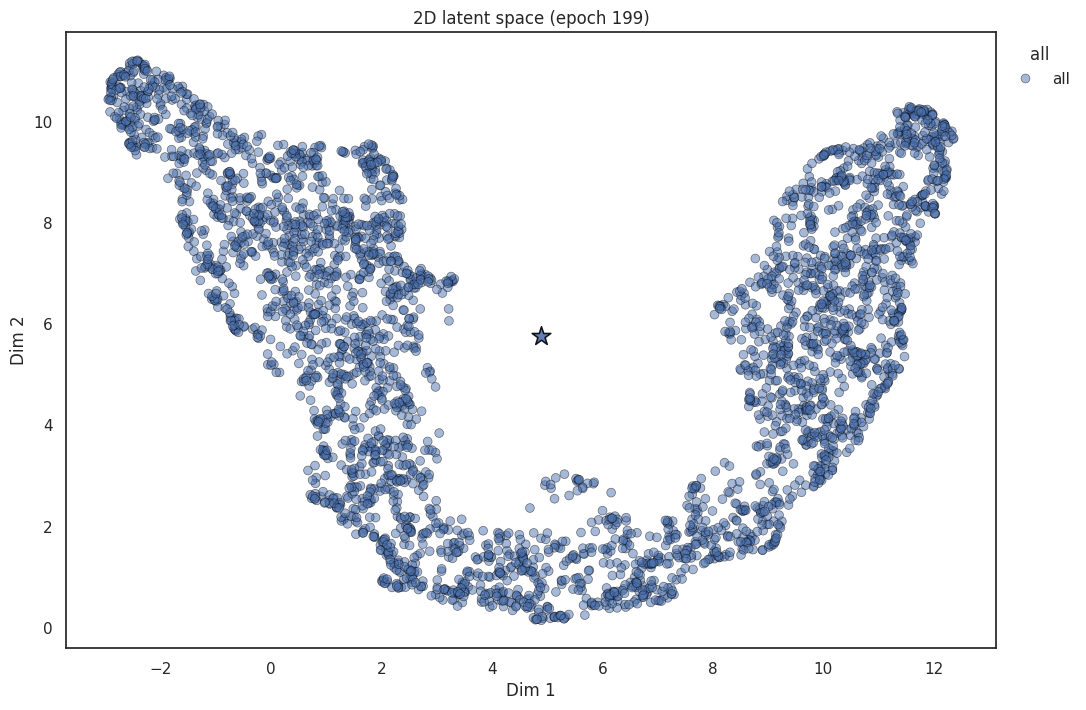

In [1]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


# sample_data = np.random.rand(1000, 100)
sample_data = pd.read_parquet('../data/RNA_data.parquet')
sample_data = sample_data.to_numpy()

my_config = DefaultConfig(learning_rate=0.0001, epochs=200, checkpoint_interval=1, beta=0.01, latent_dim=4,n_layers=2 ,batch_size=64)

custom_train_indices, custom_valid_indices, custom_test_indices = np.split(
	np.arange(len(sample_data)),
	[int(.6*len(sample_data)), int(.8*len(sample_data))])



# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}


varix = acx.Varix(data=sample_data, config=my_config, custom_splits=custom_split)
result = varix.run()


## Show 1-3 most relevant plots like loss, latent space, ... 
varix.show_result()



## Getting visualization with Annotation data/param and for specific epoch or split

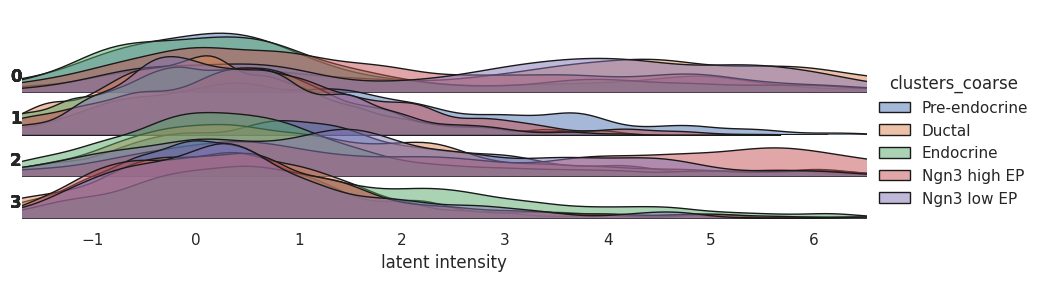

In [3]:
sample_anno= pd.read_parquet('../data/ANNO_data.parquet')

label_list_all = list(sample_anno.iloc[
	np.concatenate((
		custom_train_indices,
		custom_valid_indices,
		custom_test_indices
	), axis=0),:].loc[:,
	'clusters_coarse'])

varix._visualizer.show_latent_space(result=varix.result, type="Ridgeline", split='all', label_list=label_list_all, param='clusters_coarse', epoch=100)

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


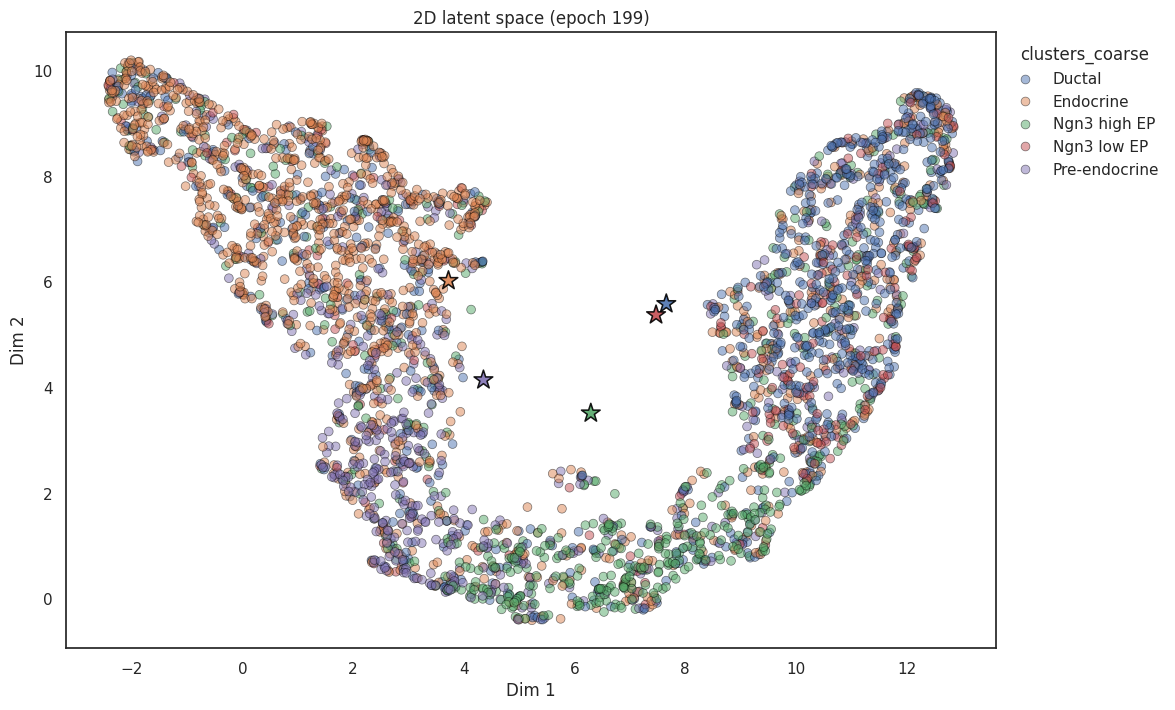

In [4]:
varix._visualizer.show_latent_space(result= varix.result, type="2D-scatter", split='all', label_list=label_list_all, param='clusters_coarse')

## Save Plots

In [5]:
varix._visualizer.save_plots(path='./my_varix_plots/', which='all', format='png')

## Model weight visualization development

In [6]:
result.model

_FabricModule(
  (_forward_module): VarixArchitecture(
    (_encoder): Sequential(
      (0): Linear(in_features=500, out_features=125, bias=True)
      (1): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=125, out_features=31, bias=True)
      (5): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): ReLU()
    )
    (_mu): Linear(in_features=31, out_features=4, bias=True)
    (_logvar): Linear(in_features=31, out_features=4, bias=True)
    (_decoder): Sequential(
      (0): Linear(in_features=4, out_features=31, bias=True)
      (1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=31, out_features=125, bias=True)
      (5): BatchNorm1d(125, eps=1e-05, momentum=0.1, af

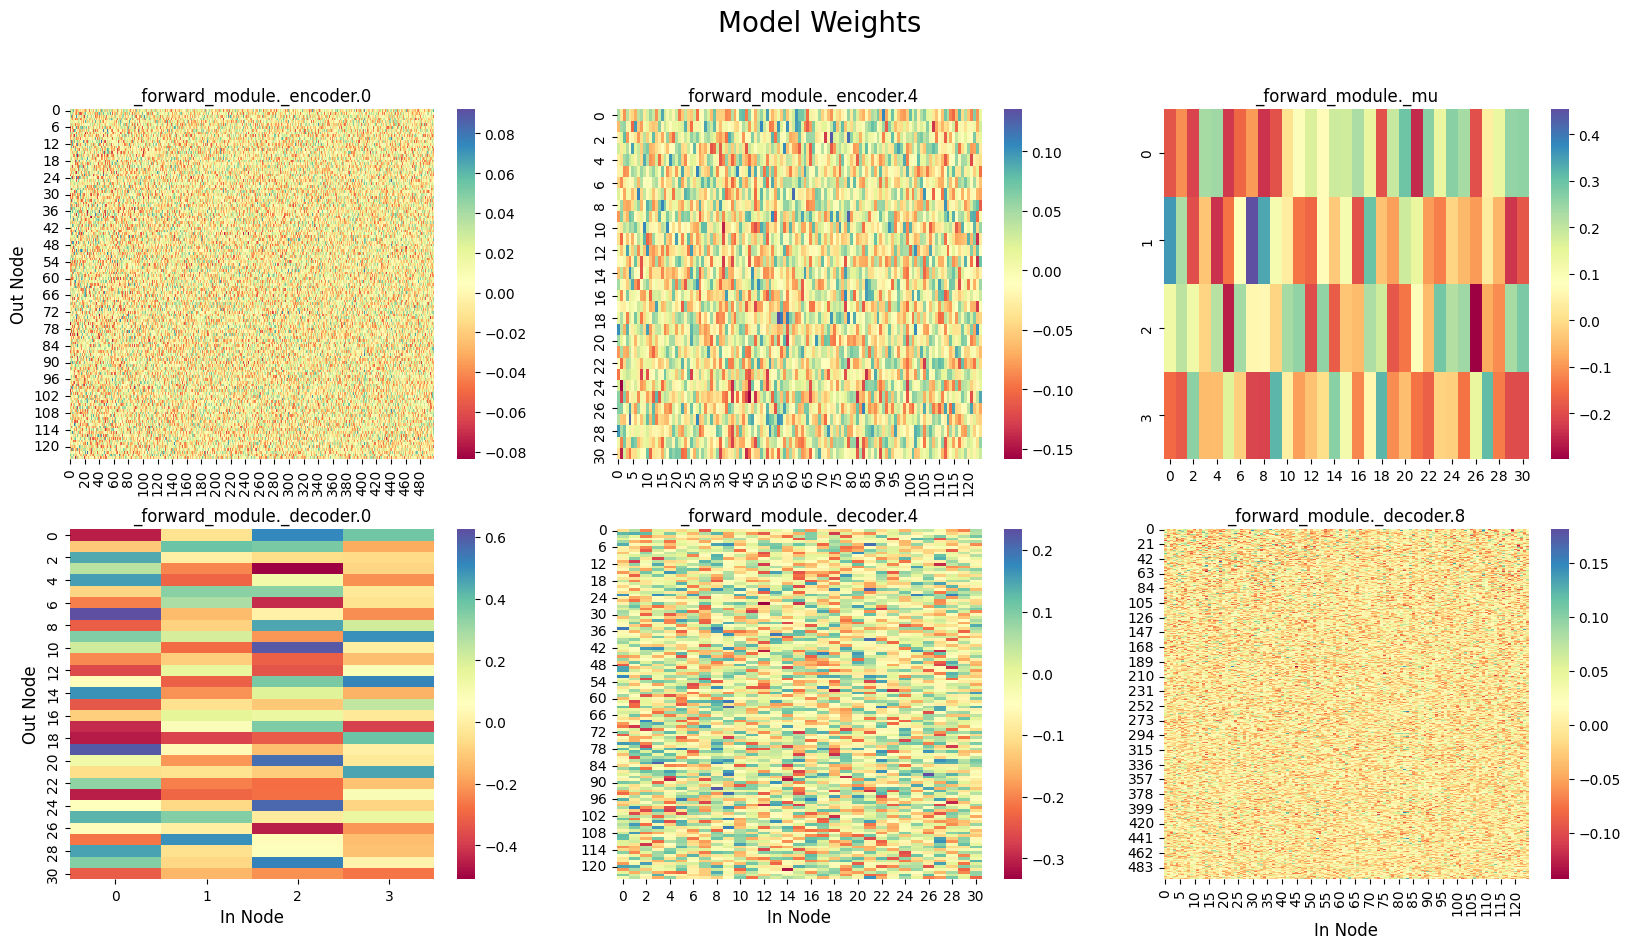

In [7]:
varix._visualizer.show_weights()

## Loss plot development

## 2D visualization

## Make Animation of latent space evolving over epochs?

In [ ]:
# TODO
# import matplotlib.animation as animation

# # Function to update the ridgeline plot for each epoch
# def update(epoch):
# 	# plt.clf()
# 	g = show_latent_space(type="Ridgeline", split='all', label_list=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', epoch=epoch)
# 	# plt.title(f'Epoch {epoch}')
# 	plt.close()
# 	return g

# # Create the figure
# fig = plt.figure(figsize=(12, 8))

# # Create the animation
# # ani = animation.FuncAnimation(fig, update, frames=range(varix.config.epochs), repeat=False)
# ani = animation.FuncAnimation(fig, update, frames=range(10), repeat=False)


# # Save the animation as a GIF
# ani.save('ridgeline_animation.gif', writer='imagemagick')

# # Display the animation
# plt.show()

## UMAP on Input for comparison

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


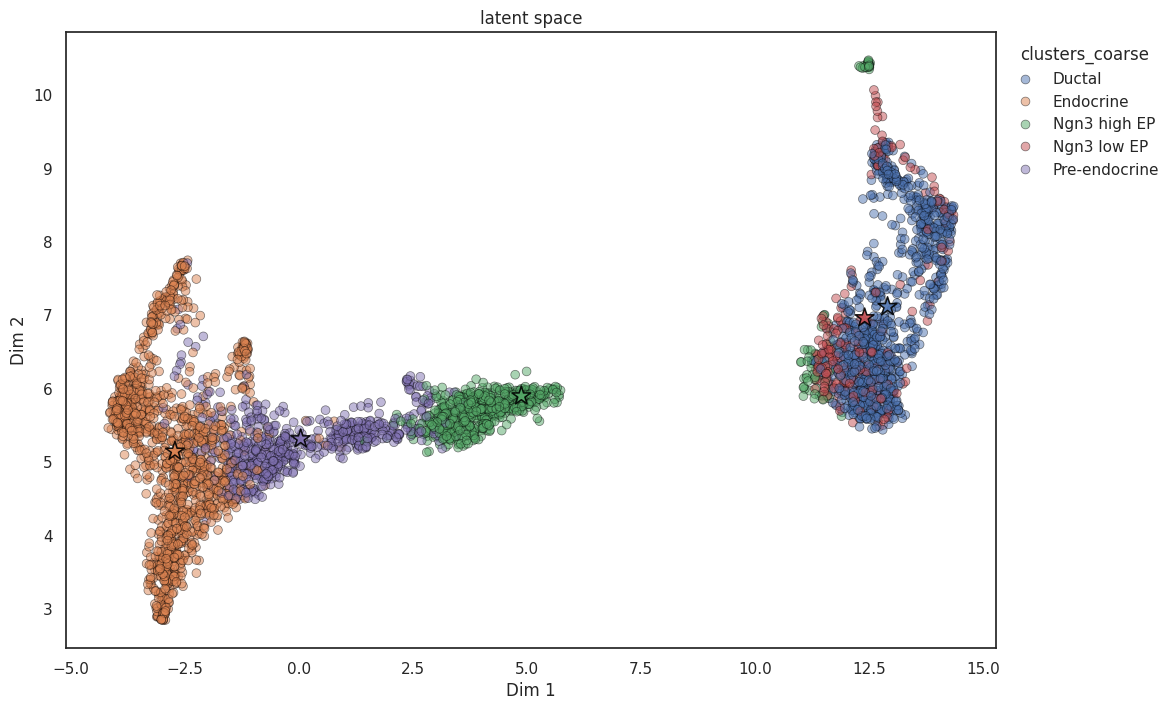

In [9]:
# TODO
import umap
# from autoencodix.visualize.Visualizer import plot_2D

reducer = umap.UMAP(n_components=2 )

input_embedding = pd.DataFrame(reducer.fit_transform(result.preprocessed_data))
varix._visualizer.plot_2D(embedding=input_embedding, labels=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', layer='latent space', figsize=(12, 8), center=True)
